In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
info_job_level_dfs = {}
spatial_job_level_dfs = {}
spatial_burstiness_dfs = {}
info_job_level_dfs["gpu_utilization"] = pd.read_csv("job_level_gpu_utilization.csv")
spatial_job_level_dfs["gpu_utilization"] = pd.read_csv("spatial_job_level_gpu_utilization.csv") 
spatial_burstiness_dfs["gpu_utilization"] = pd.read_csv("spatial_burstiness_job_level_gpu_utilization.csv")

In [3]:
gputil_all = info_job_level_dfs["gpu_utilization"]
gputil_30 = gputil_all[gputil_all['mean_utilization'] <= 30]
gputil_30_70 = gputil_all[(gputil_all['mean_utilization'] > 30) & (gputil_all['mean_utilization'] < 70)]
gputil_70 = gputil_all[(gputil_all['mean_utilization'] >= 70) & (gputil_all['mean_utilization'] <= 100)] 

In [4]:
gputil_spatial_30 = pd.merge(gputil_30, spatial_job_level_dfs["gpu_utilization"][['jobid', 'spatial_imbalance_gpu_utilization']], on='jobid', how='left').dropna()
gputil_spatial_30_70 = pd.merge(gputil_30_70, spatial_job_level_dfs["gpu_utilization"][['jobid', 'spatial_imbalance_gpu_utilization']], on='jobid', how='left').dropna()
gputil_spatial_70 = pd.merge(gputil_70, spatial_job_level_dfs["gpu_utilization"][['jobid', 'spatial_imbalance_gpu_utilization']], on='jobid', how='left').dropna()

In [5]:
high_spatial_imbalance_jobs = spatial_job_level_dfs["gpu_utilization"][spatial_job_level_dfs["gpu_utilization"]["spatial_imbalance_gpu_utilization"] > 0.5]
high_spatial_imbalance_jobs

,jobid,ngpus,spatial_imbalance_gpu_utilization,max_gpu_utilization_sum
0,9713267,88,0.726080,338.0
1,9942816,4,0.750000,594.0
2,9942821,4,0.750000,594.0
3,9942853,4,0.750000,693.0
4,9942854,4,0.750000,594.0
...,...,...,...,...
344915,19425434,4,0.750000,600.0
344947,19425596,4,0.710833,600.0
345070,19426673,4,0.750000,174.0
345071,19426679,4,0.750000,600.0


In [6]:
spatial_burstiness = spatial_burstiness_dfs["gpu_utilization"][spatial_burstiness_dfs["gpu_utilization"]["jobid"].isin(list(high_spatial_imbalance_jobs["jobid"]))]
spatial_burstiness

,jobid,burstiness_score
0,9713267,-0.320778
1,9942816,0.000000
2,9942821,0.000000
3,9942853,0.000000
4,9942854,0.000000
...,...,...
344915,19425434,0.000000
344947,19425596,0.000000
345070,19426673,0.000000
345071,19426679,0.000000


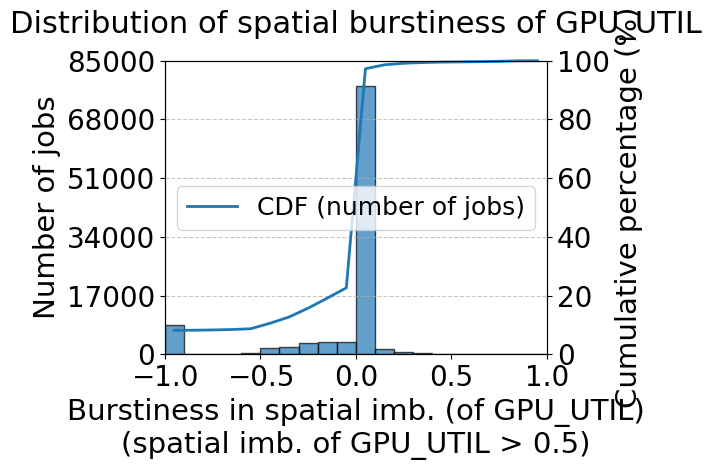

In [7]:
burstiness_values = spatial_burstiness["burstiness_score"].dropna()  
hist_values, bin_edges = np.histogram(burstiness_values, bins=20, range=(-1,1))

cumulative_values = np.cumsum(hist_values)
cdf = (cumulative_values / cumulative_values[-1]) * 100 

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

fig, ax1 = plt.subplots()
ax1.hist(burstiness_values, bins=20, edgecolor='black', alpha=0.7, range=(-1,1))
ax1.set_xlabel("Burstiness in spatial imb. (of GPU_UTIL)\n(spatial imb. of GPU_UTIL > 0.5)", fontsize=21)
ax1.set_ylabel("Number of jobs", fontsize=21)
ax1.set_xticks([-1, -0.5, 0, 0.5, 1.0])
ax1.set_yticks([0, 17000, 34000, 51000, 68000, 85000])
ax1.set_ylim(0, 85000)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.set_xlim(-1, 1)

ax2 = ax1.twinx()
ax2.plot(bin_centers, cdf, label='CDF (number of jobs)', linewidth=2, clip_on=False)
ax2.set_ylabel('Cumulative percentage (%)', fontsize=21)
ax2.set_yticks([0, 20, 40, 60, 80, 100])  
ax2.set_ylim(0, 100)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend(loc="center right", fontsize=18)

plt.title("Distribution of spatial burstiness of GPU_UTIL", fontsize=22, pad=20)
plt.tight_layout()
plt.show()